In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
# importing packages
import os, sys
import pandas as pd
import numpy as np
import warnings

# setting project path
gparent = os.path.join(os.pardir, os.pardir)
sys.path.append(gparent)

from src import helper_functions as f
from src import visualizations as v
from src import class_Database as d
from src import class_Harness as h

from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import OneHotEncoder, StandardScaler, MinMaxScaler
from sklearn.compose import make_column_selector, make_column_transformer
from sklearn.pipeline import make_pipeline 
from sklearn.metrics import (accuracy_score, recall_score, precision_score,
                             f1_score, make_scorer)
from sklearn.dummy import DummyClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier, export_graphviz, plot_tree
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier

from imblearn.over_sampling import SMOTE
from imblearn.pipeline import make_pipeline as make_sm_pipeline

import matplotlib.pyplot as plt
import seaborn as sns

sns.set_theme('talk')
plt.style.use('fivethirtyeight')
sns.set_palette("winter_r")
pd.options.display.max_rows = 300

## Creating The Database

In [3]:
# creating database & database class instance
database_name = 'outcomes.db'
db = d.Database(database_name)

**Run The Cell Below Once And Then Comment Out**

In [4]:
# file_name = 'anonymisedData.zip'
# db.populate(file_name, database_name)

### Database ERD

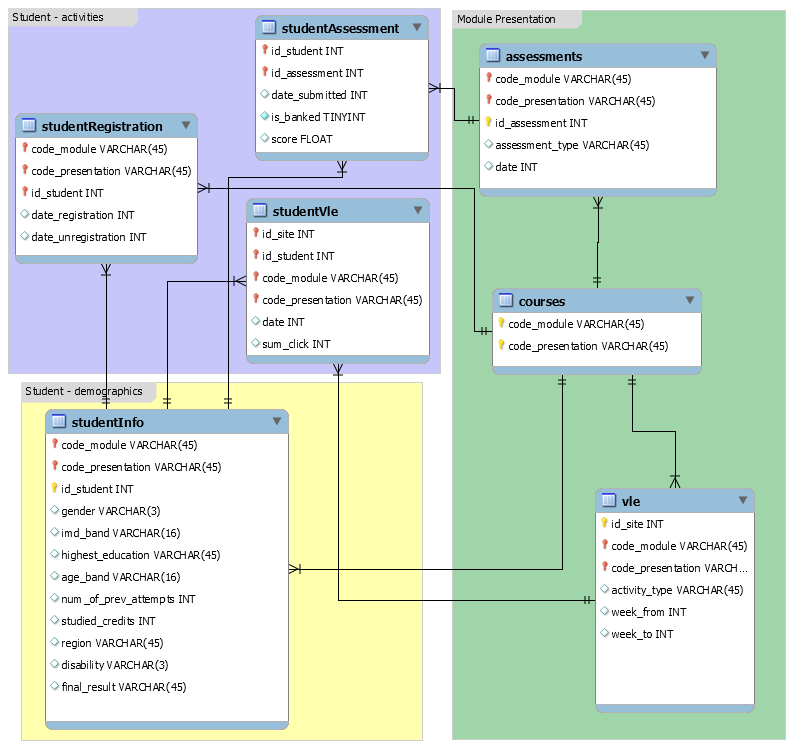

In [5]:
db.erd

## Preprocessing and Harness Objects

In [6]:
string_selector = make_column_selector(dtype_include='object')
number_selector = make_column_selector(dtype_include='number', dtype_exclude='object')

preprocessing_ohe = make_column_transformer((OneHotEncoder
                                         (handle_unknown='ignore'),string_selector))

preprocessing_ss = make_column_transformer((OneHotEncoder
                                         (handle_unknown='ignore'),string_selector),
                                          (StandardScaler(), number_selector))
preprocessing_mm = make_column_transformer((OneHotEncoder
                                         (handle_unknown='ignore'),string_selector),
                                          (MinMaxScaler(), number_selector))
sm = SMOTE(random_state=2021)

In [7]:
# creating f1 scorer
f1 = f.f1

# creating recall scorer 
recall = f.recall

# creating precision scorer
precision = f.precision

# creating Harness
modeling = h.Harness(('f1', 'recall', 'precision'))

## STUDENTINFO Table

In [8]:
db.table_info('STUDENTINFO')

[(0, 'code_module', 'TEXT', 0, None, 0),
 (1, 'code_presentation', 'TEXT', 0, None, 0),
 (2, 'id_student', 'TEXT', 0, None, 0),
 (3, 'gender', 'TEXT', 0, None, 0),
 (4, 'region', 'TEXT', 0, None, 0),
 (5, 'highest_education', 'TEXT', 0, None, 0),
 (6, 'imd_band', 'TEXT', 0, None, 0),
 (7, 'age_band', 'TEXT', 0, None, 0),
 (8, 'num_of_prev_attempts', 'TEXT', 0, None, 0),
 (9, 'studied_credits', 'TEXT', 0, None, 0),
 (10, 'disability', 'TEXT', 0, None, 0),
 (11, 'final_result', 'TEXT', 0, None, 0)]

### Creating STUDENTINFO Data Frame

In [9]:
df = db.student_info()

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 31482 entries, 0 to 32592
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype   
---  ------                --------------  -----   
 0   target                31482 non-null  int64   
 1   code_module           31482 non-null  object  
 2   code_presentation     31482 non-null  object  
 3   id_student            31482 non-null  object  
 4   gender                31482 non-null  object  
 5   region                31482 non-null  object  
 6   highest_education     31482 non-null  object  
 7   imd_band              31482 non-null  object  
 8   age_band              31482 non-null  object  
 9   num_of_prev_attempts  31482 non-null  object  
 10  disability            31482 non-null  object  
 11  course_load           31482 non-null  category
dtypes: category(1), int64(1), object(10)
memory usage: 2.9+ MB


In [11]:
df.target.value_counts(normalize=True)

0    0.534496
1    0.465504
Name: target, dtype: float64

## Creating Holdout Data

In [12]:
X, y = f.X_y(df)

In [13]:
X_training, X_holdout, y_training, y_holdout = f.test_train(X, y)

## Creating Training Data

In [14]:
X_train, X_test, y_train, y_test = f.test_train(X_training, y_training)

## Baseline Model: Dummy Classifier

In [15]:
dummy = DummyClassifier(strategy='most_frequent')

In [16]:
baseline = make_pipeline(preprocessing_ohe, dummy)

### Fitting Model

In [17]:
baseline.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x161b472e0>)])),
                ('dummyclassifier', DummyClassifier(strategy='most_frequent'))])

In [18]:
# path = os.path.join(gparent, 'models', 'baseline.pkl')

In [19]:
# file = open(path, 'wb')
# pickle.dump(baseline, file)
# file.close()

### Cross Val Scores

In [20]:
with warnings.catch_warnings():
    warnings.simplefilter('ignore')
    modeling.report(baseline, X_train, y_train, ' Baseline', 'Dummy')

 Baseline has an average F1 of 0.0
 Baseline has an average Recall of 0.0
 Baseline has an average Precision of 0.0


### Test Data Confusion Matrix

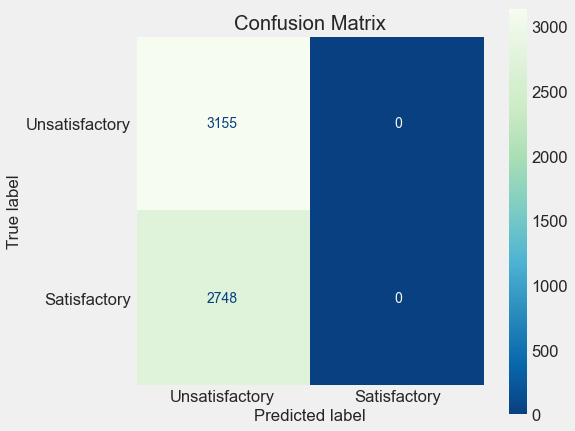

,F1,Recall,Precision
0,0.0,0.0,0.0


In [21]:
%%capture --no-display
f.confusion_report(baseline, X_test, y_test)

## First Simple Model: Naive Bayes Classifier

In [22]:
mnb = MultinomialNB()

In [23]:
fsm = make_pipeline(preprocessing_ohe, mnb)

### Fitting Model

In [24]:
fsm.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x161b472e0>)])),
                ('multinomialnb', MultinomialNB())])

In [25]:
# path = os.path.join(gparent, 'models', 'fsm.pkl')

In [26]:
# file = open(path, 'wb')
# pickle.dump(fsm, file)
# file.close()

### Cross Val Scores

In [27]:
# checking cross val scores
modeling.report(fsm, X_train, y_train, ' Baseline', 'Naive Bayes')

 Baseline has an average F1 of 0.4943672264162995
 Baseline has an average Recall of 0.40980367624980135
 Baseline has an average Precision of 0.6235759589938843


[0.4943672264162995, 0.40980367624980135, 0.6235759589938843]

### Test Data Confusion Matrix

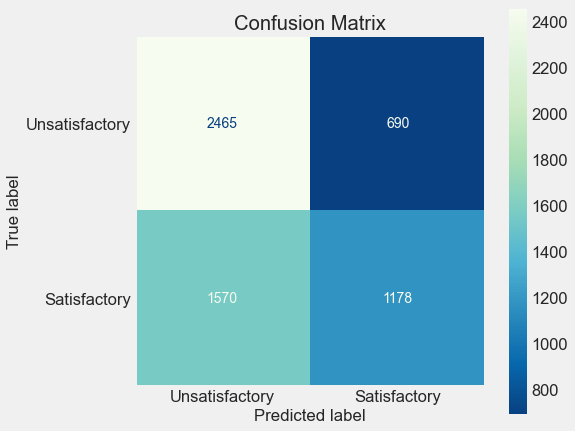

,F1,Recall,Precision
0,0.510399,0.428675,0.630621


In [28]:
f.confusion_report(fsm, X_test, y_test)

## KNeighborsClassifier

In [29]:
KNN = KNeighborsClassifier(n_jobs=-1)

In [30]:
knn = make_pipeline(preprocessing_ohe, KNN)

### Fitting Model

In [31]:
knn.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x161b472e0>)])),
                ('kneighborsclassifier', KNeighborsClassifier(n_jobs=-1))])

In [32]:
# path = os.path.join(gparent, 'models', 'knn.pkl')

In [33]:
# file = open(path, 'wb')
# pickle.dump(knn, file)
# file.close()

### Cross Val Scores

In [34]:
# checking cross val scores
modeling.report(knn, X_train, y_train, 'knn', 'KNN')

knn has an average F1 of 0.5230115099742918
knn has an average Recall of 0.5106154362455622
knn has an average Precision of 0.5360632442523018


[0.5230115099742918, 0.5106154362455622, 0.5360632442523018]

### Test Data Confusion Matrix

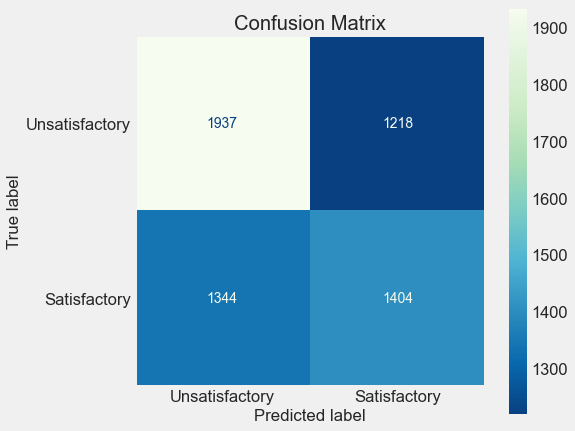

,F1,Recall,Precision
0,0.522905,0.510917,0.535469


In [35]:
f.confusion_report(knn, X_test, y_test)

## Logistic Regression Classifier

In [36]:
LR = LogisticRegression(max_iter=1000, n_jobs=-1, random_state = 2021, verbose=2)

In [37]:
logreg = make_pipeline(preprocessing_ohe, LR)

### Fitting Model

In [38]:
logreg.fit(X_train, y_train)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    3.6s finished


Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x161b472e0>)])),
                ('logisticregression',
                 LogisticRegression(max_iter=1000, n_jobs=-1, random_state=2021,
                                    verbose=2))])

In [39]:
# path = os.path.join(gparent, 'models', 'logreg.pkl')

In [40]:
# file = open(path, 'wb')
# pickle.dump(logreg, file)
# file.close()

### Cross Val Scores

In [41]:
# checking cross val scores
modeling.report(logreg, X_train, y_train, 'logreg', 'Logistic Regression')

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    2.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    1.9s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.6s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    2.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.6s finished


logreg has an average F1 of 0.5636097570237412
logreg has an average Recall of 0.5267501781014678
logreg has an average Precision of 0.6062986158636052


[0.5636097570237412, 0.5267501781014678, 0.6062986158636052]

### Test Data Confusion Matrix

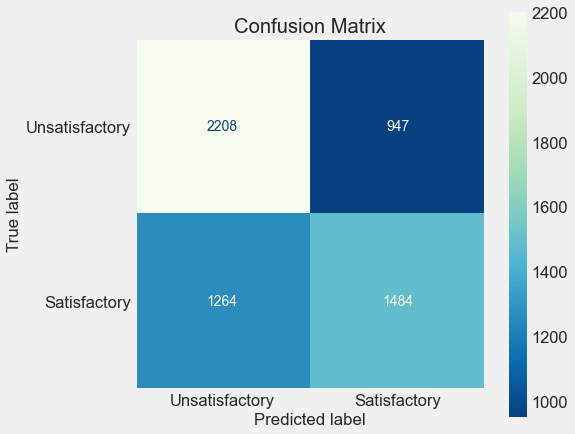

,F1,Recall,Precision
0,0.573084,0.540029,0.610448


In [42]:
f.confusion_report(logreg, X_test, y_test)

In [45]:
modeling.history

,Name,F1,Recall,Precision,Notes
0,Baseline,0.000000,0.000000,0.000000,Dummy
1,Baseline,0.494367,0.409804,0.623576,Naive Bayes
2,knn,0.523012,0.510615,0.536063,KNN
3,logreg,0.563610,0.526750,0.606299,Logistic Regression


### STUDENTINFO & STUDENTVLE

In [43]:
df = db.sv_si()

In [44]:
df.head()

,target,code_module,code_presentation,id_student,id_site,date,sum_click,click_sum,gender,region,highest_education,imd_band,age_band,num_of_prev_attempts,disability,course_load
0,1,AAA,2013J,100893,547013,-9,1,744,Male,Yorkshire Region,A Level or Equivalent,20-30%,0-35,0,No,Light
1,1,AAA,2013J,101781,546614,-10,5,4104,Male,South Region,Lower Than A Level,80-90%,35-55,0,No,Light
2,1,AAA,2013J,102806,546719,-10,3,1944,Male,North Western Region,A Level or Equivalent,30-40%,0-35,0,No,Light
3,1,AAA,2013J,102952,546879,-3,1,1150,Male,London Region,HE Qualification,60-70%,0-35,0,No,Light
4,1,AAA,2013J,1035023,546652,-10,1,1896,Female,London Region,Lower Than A Level,30-40%,35-55,0,No,Light
